In [60]:
import math, glob, time, os, re, json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
plt.rcParams.update({'font.size': 22})

from katrain.core.base_katrain import KaTrainBase
from katrain.core.game import Game, KaTrainSGF
from katrain.core.engine import KataGoEngine

In [2]:
kt = KaTrainBase()

Using user config file /home/sander/.katrain/config.json


In [3]:
e_config = kt.config("engine")
e_config["max_visits"] = e_config["fast_visits"] = 1  # since it's just policy anyway
e_config["threads"] = 64
e_config

{'katago': '',
 'model': 'katrain/models/g170e-b15c192-s1672170752-d466197061.bin.gz',
 'config': 'katrain/KataGo/analysis_config.cfg',
 'threads': 64,
 'max_visits': 1,
 'fast_visits': 1,
 'max_time': 3.0,
 'wide_root_noise': 0.0,
 '_enable_ownership': True}

In [4]:
engine = KataGoEngine(kt, e_config)

In [66]:
PLAYERS={'W':'white','B':'black'}
def get_policy_stats(game):
    game.redo(999)
    moves = game.current_node.nodes_from_root[1:]  # without root
    while not all(m.analysis_ready for m in moves):
        time.sleep(0.01)

    parent_policy_per_move = [move.parent.policy_ranking for move in moves]
    num_legal_moves = [sum(pv >= 0 for pv, _ in policy_ranking) for policy_ranking in parent_policy_per_move]
    policy_stats = [
        [(move_num, num_mv, rank, value, policy_ranking[0][0], PLAYERS[mv.player]) for rank, (value, mv) in enumerate(policy_ranking) if mv == move.move][0]
        for move_num,(move, policy_ranking, num_mv) in enumerate(zip(moves, parent_policy_per_move, num_legal_moves))
    ]
    return policy_stats


def rank_to_kyu(r):
    return 30-r

def outlier_free_stats(data):
    sorteddata = sorted(data)
    lendata = len(data)
    selected = sorteddata[int(lendata*.2):int(lendata*.8)+1]
    return np.mean(selected)

In [ ]:
games_data = pd.DataFrame(columns=['bot','bot_rank','user','user_rank','user_color','winner','outcome'])
moves_data = []


for filename in tqdm(glob.glob("sgf_ogs/*.sgf")):
    sgf = KaTrainSGF.parse_file(filename)

    gamedata_str = re.search('Gamedata:(.*)SGF with review',sgf.properties['C'][0],re.DOTALL)[1]
    gamedata = json.loads(gamedata_str)
    outcome = gamedata['outcome']
    rank = {p:rank_to_kyu(gamedata['players'][p]['rank']) for p in ['white','black']}
    players = {p:gamedata['players'][p]['username'] for p in ['white','black']}
    ids = {p:gamedata['players'][p]['id'] for p in ['white','black']}
    bot_player = 'black' if 'katrain-' in players['black'] else 'white'
    non_bot_player = 'black' if bot_player=='white' else 'white'
    winner = 'black' if gamedata['winner']==ids['black'] else 'white'
    gameid = gamedata['game_id']

    if outcome == 'Cancellation' or sgf.board_size!=(19,19) or not gamedata['ranked']:
        continue

    try:
        game = Game(kt, engine, move_tree=sgf)
        move_analysis =  [ (gameid,*stats,non_bot_player) for stats in get_policy_stats(game) ] 
    except Exception as e:
        print(f"Error in analyzing {filename}: {e}") # branching etc
        continue
        
    games_data.loc[gameid] = (players[bot_player],rank[bot_player],
                          players[non_bot_player],rank[non_bot_player],non_bot_player,
                          winner,outcome)
    game = Game(kt, engine, move_tree=sgf)
    moves_data.append(move_analysis)
    
moves_data = pd.DataFrame( sum(moves_data,[]),    
    columns=['game_id','move','num_legal','policy_rank','policy_value','top_value','move_color','user_color'])

In [79]:
moves_data

,game_id,move,num_legal,policy_rank,policy_value,top_value,move_color,user_color
0,24608849,0,362,10,0.060001,0.086744,black,black
1,24608849,1,361,2,0.238003,0.260762,white,black
2,24608849,2,360,3,0.098470,0.216903,black,black
3,24608849,3,359,0,0.547250,0.547250,white,black
4,24608849,4,358,6,0.007594,0.344654,black,black
...,...,...,...,...,...,...,...,...
137003,24607102,404,75,1,0.115328,0.326293,black,white
137004,24607102,405,86,1,0.108052,0.208301,white,white
137005,24607102,406,93,20,0.008818,0.327489,black,white
137006,24607102,407,84,1,0.121942,0.203890,white,white


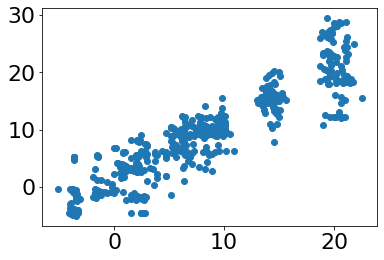

In [57]:
plt.scatter(games_data.bot_rank,games_data.user_rank)

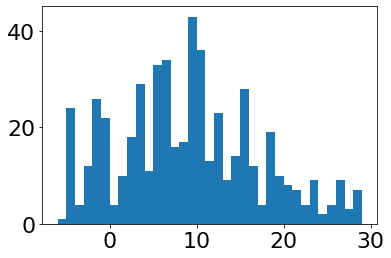

In [58]:
plt.hist(games_data.user_rank,bins=range(-6,30));

In [74]:
user_moves = moves_data[moves_data.move_color==moves_data.user_color]
user_moves['rank'] = games_data.loc[user_moves.game_id].user_rank.values

bot_moves = moves_data[moves_data.move_color!=moves_data.user_color]
bot_moves['rank'] = games_data.loc[bot_moves.game_id].bot_rank.values
labels = ['users','bots']

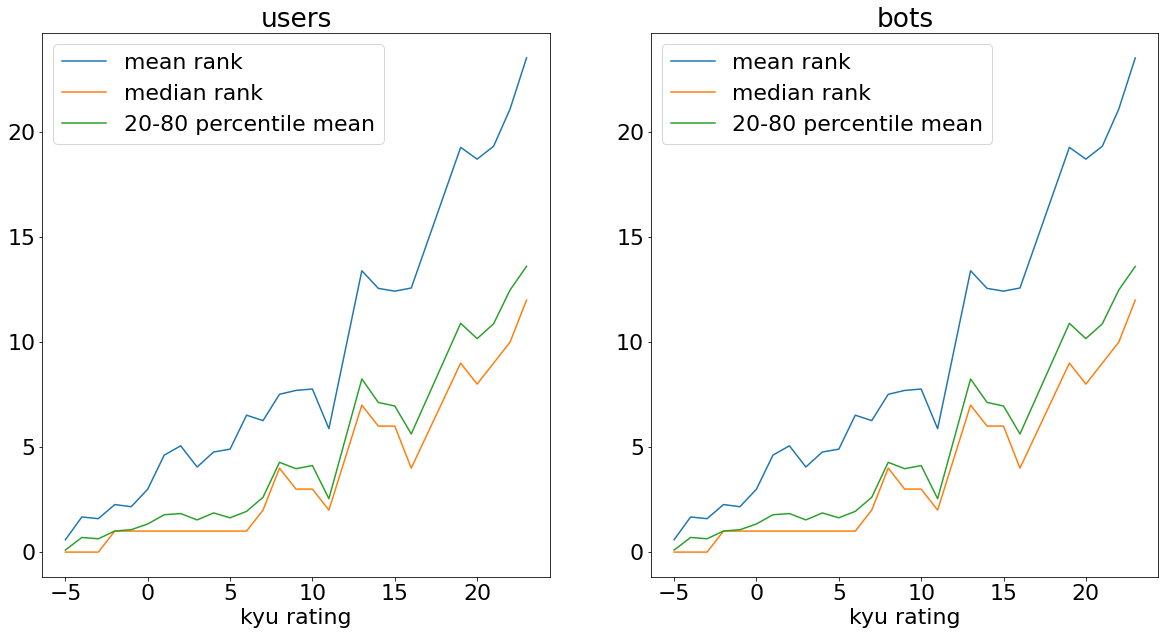

In [75]:
plt.figure(figsize=(20,10))
for i,stats in enumerate([user_moves,bot_moves]):
    stats = [(r,df.policy_rank.mean(),df.policy_rank.median(),outlier_free_stats(df.policy_rank.values),df.shape[0]) 
              for r,df in bot_moves.groupby(bot_moves['rank'].round())]    
    rank, mean, median, outlier_free_mean, sample_size = zip(*stats)
    plt.subplot(1,2,i+1)
    plt.plot(rank,mean,rank,median,rank,outlier_free_mean)
    plt.xlabel('kyu rating')
    plt.legend(['mean rank','median rank','20-80 percentile mean'])
    plt.title(labels[i])

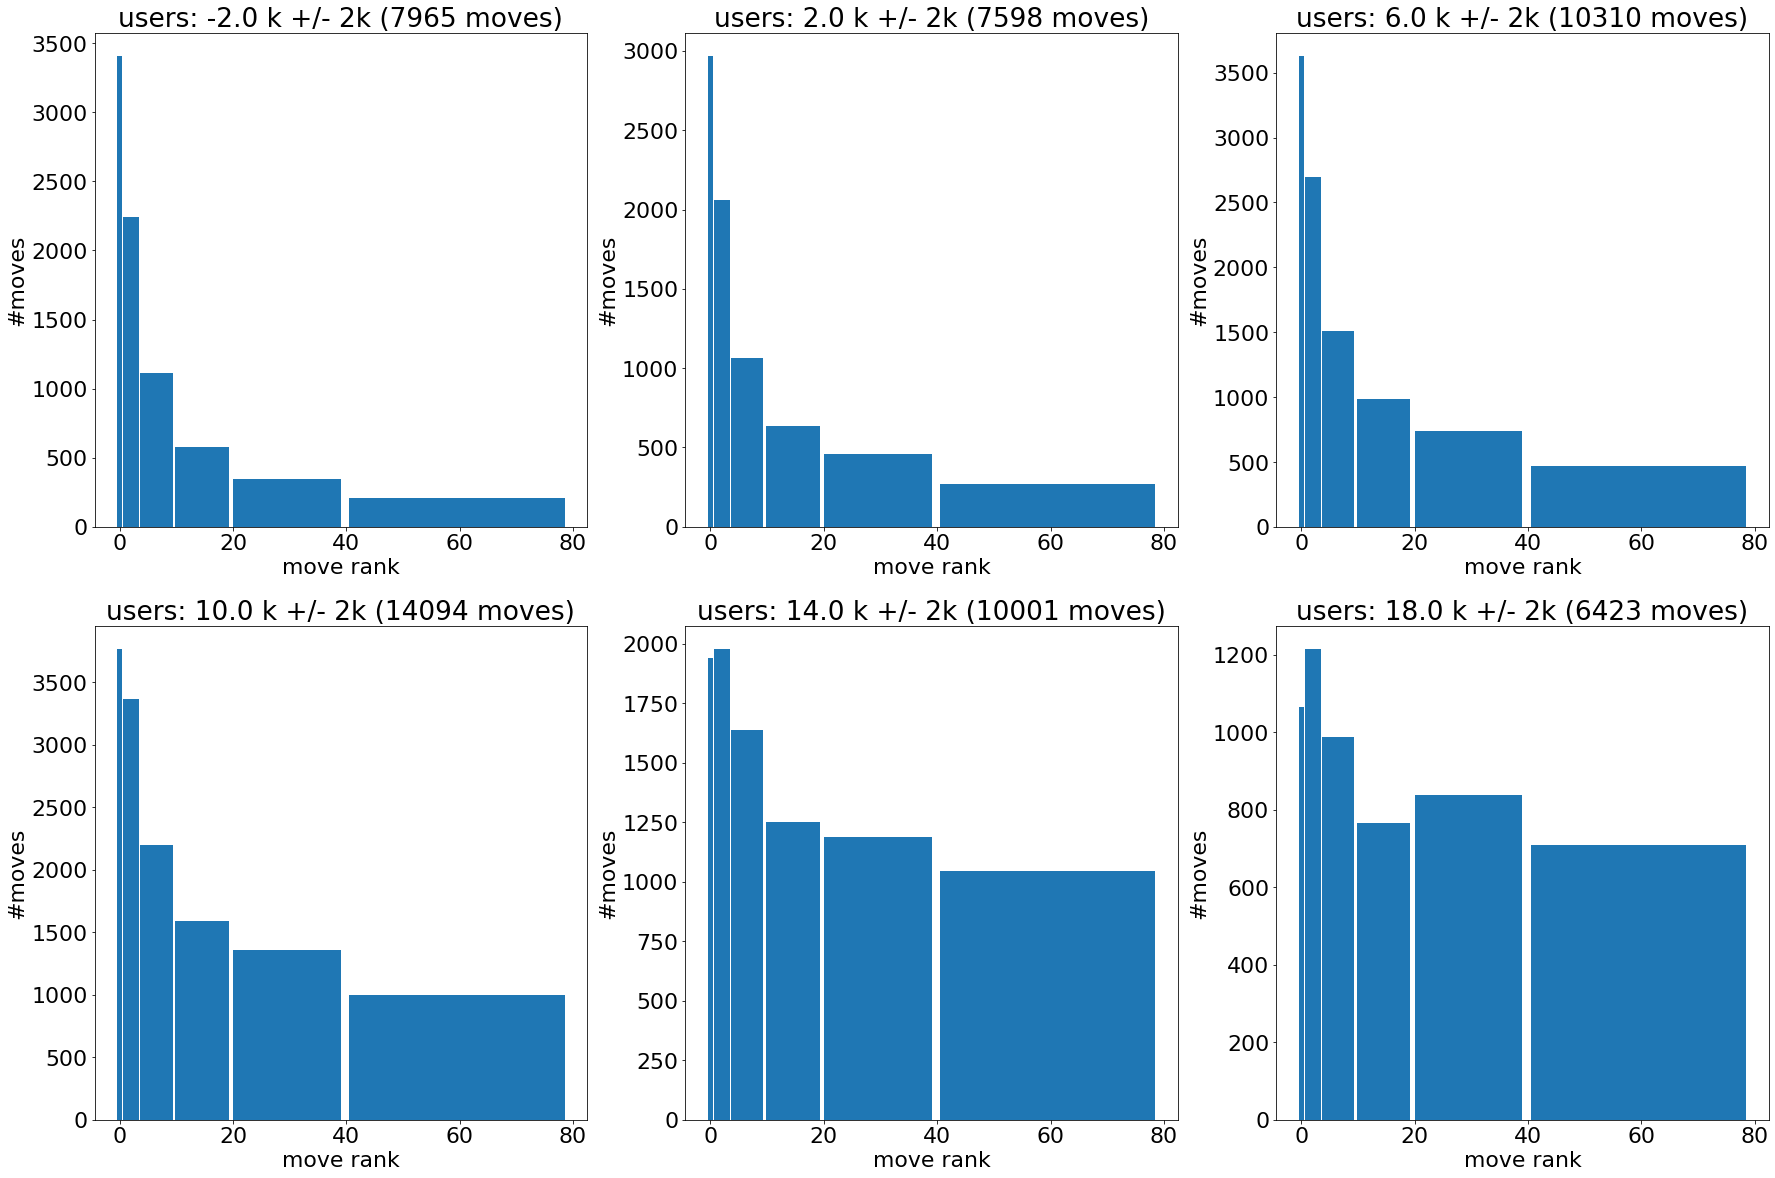

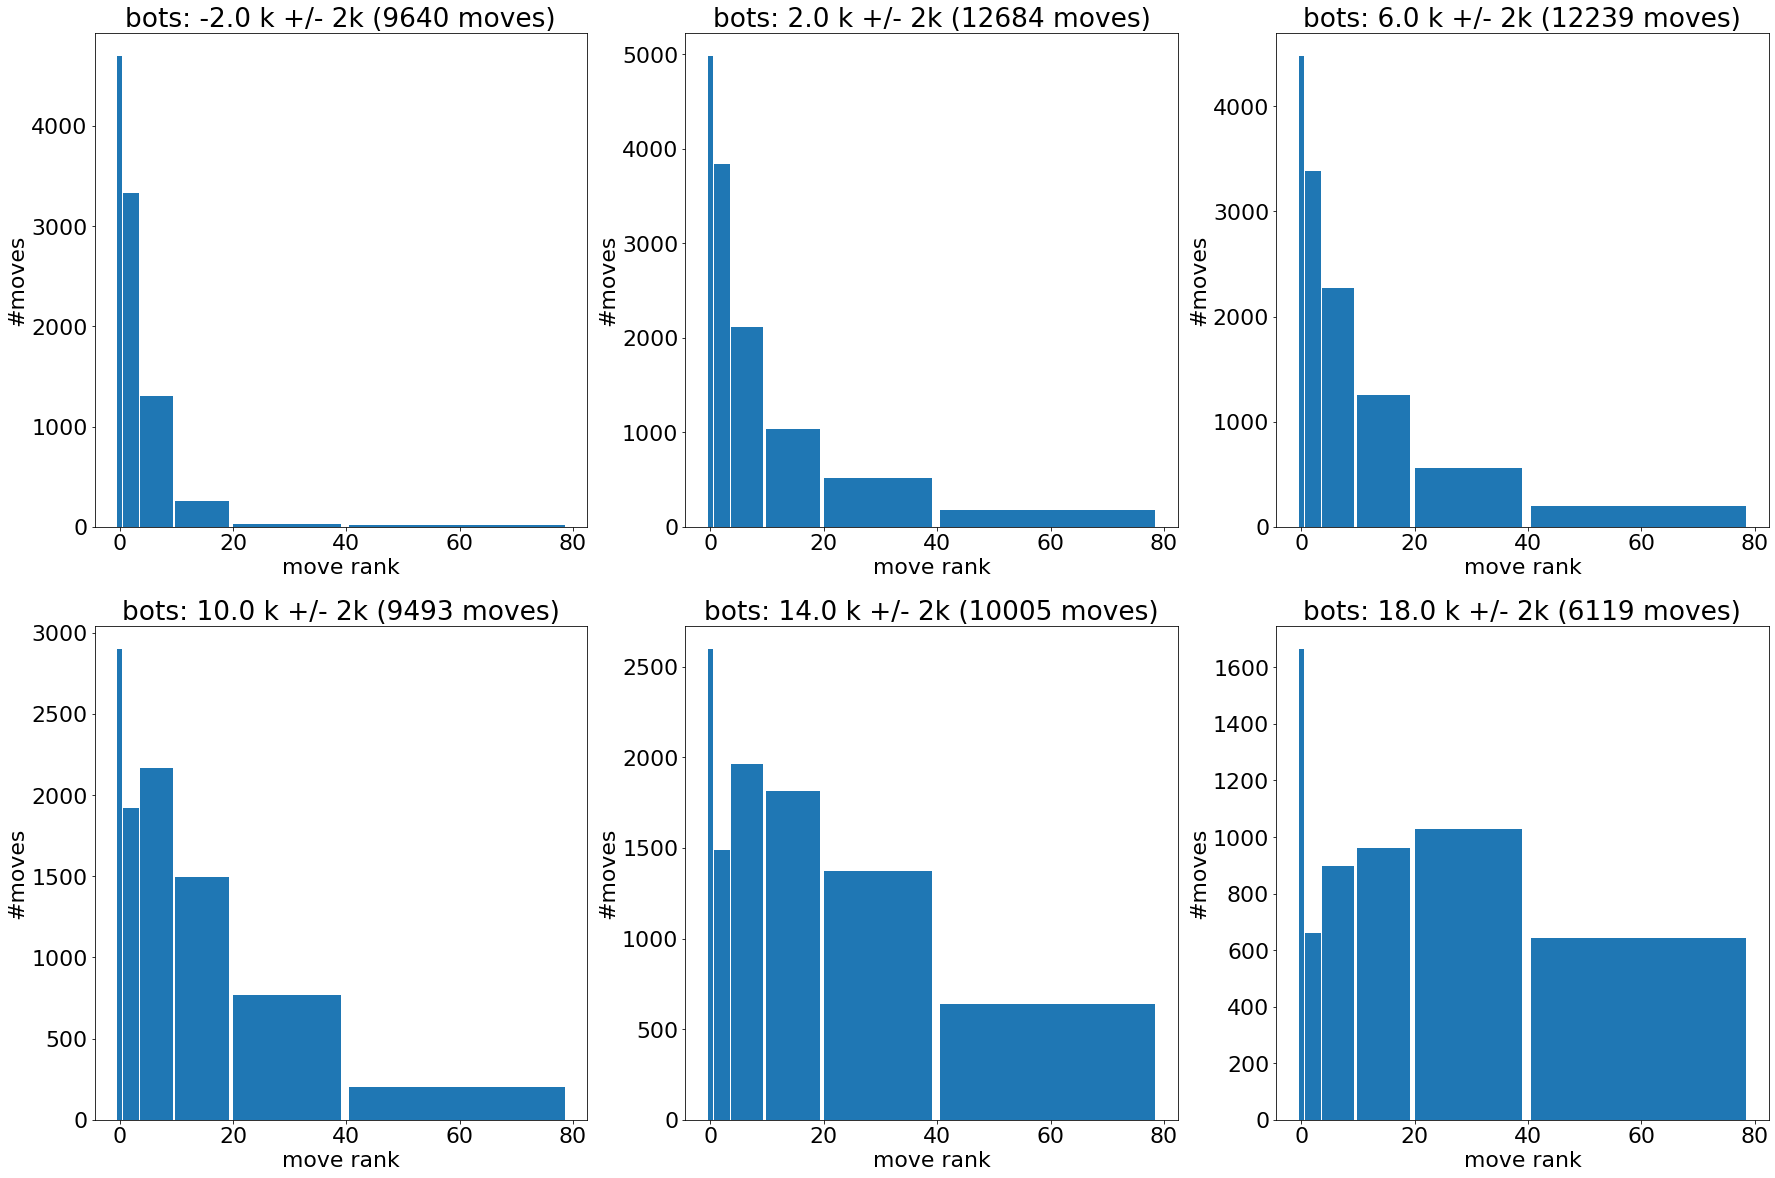

In [78]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        plt.hist(df.policy_rank.values,[-0.5,0.5,3.5,9.5,19.5,39.5,79.5],rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('move rank')
        plt.ylabel('#moves')       